In [1]:
# load all images as a dictionary
from PIL import Image
import numpy as np
import os
data_tag = {}
for subdir, dirs, files in os.walk('../yalefaces/yalefaces'):
    for f in files:
        fpath = subdir + os.sep + f
        if f != 'Icon' and f != 'Readme.txt':
            data_tag[f] = np.asarray(Image.open(fpath))
            
# prepare data - stack all rows of each image
data_vec = {}
for k,v in data_tag.items():
    data_vec[k] = np.ravel(v)

77760
[0.3047347  0.44510978 0.5338749  0.60816484 0.655441   0.69656354
 0.72417488 0.74723547 0.76981764 0.78872927 0.80221464 0.81388417
 0.82325101 0.83226701 0.8409805  0.8490386  0.85634356 0.86290604
 0.86913348 0.87514997 0.88043027 0.88527116 0.88970767 0.89392448
 0.89776249 0.90158747 0.90501478 0.90815505 0.91118334 0.91397948
 0.91673291 0.91935658 0.92187706 0.92422895 0.92651177 0.92863537
 0.93059019 0.93247037 0.93432303 0.93609596 0.93780878 0.93946944
 0.94106825 0.94260985 0.94410744 0.94557573 0.94698225 0.94834273
 0.94968956 0.95097957 0.95224268 0.9534783  0.95467796 0.95584735
 0.95698374 0.95807193 0.95913339 0.96017603 0.96119065 0.96219328
 0.96318362 0.96411177 0.96501786 0.96590307 0.96677484 0.96762546
 0.9684512  0.96926364 0.97006883 0.97084455 0.97160236 0.97235615
 0.97306995 0.97377457 0.97447145 0.97514926 0.97580807 0.97645148
 0.97708527 0.97769934 0.97830116 0.97890052 0.97947862 0.98004698
 0.98059901 0.98114815 0.98167752 0.9821996  0.98269575 

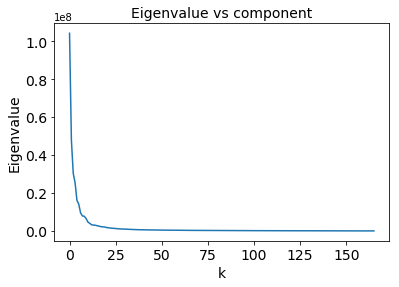

In [5]:
# compute eigen analysis on the vectors
data = data_vec.values()
data = np.array(data)
n_feat = data.shape[1]
print n_feat
#print np.mean(data, axis=0).reshape(1, n_feat).shape
data_m = np.mean(data, axis=0)
data = data - np.mean(data, axis=0)

from sklearn.decomposition import PCA
pca = PCA(n_components=data.shape[0])
pca.fit(data)
eigenvals = pca.explained_variance_
ratio = np.array([np.sum(eigenvals[:i+1])/np.sum(eigenvals) for i in range(eigenvals.shape[0])])
print ratio

import matplotlib.pyplot as plt
plt.plot(eigenvals)
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel('k', size=14)
plt.ylabel('Eigenvalue', size=14)
plt.title('Eigenvalue vs component', size=14)
plt.show()

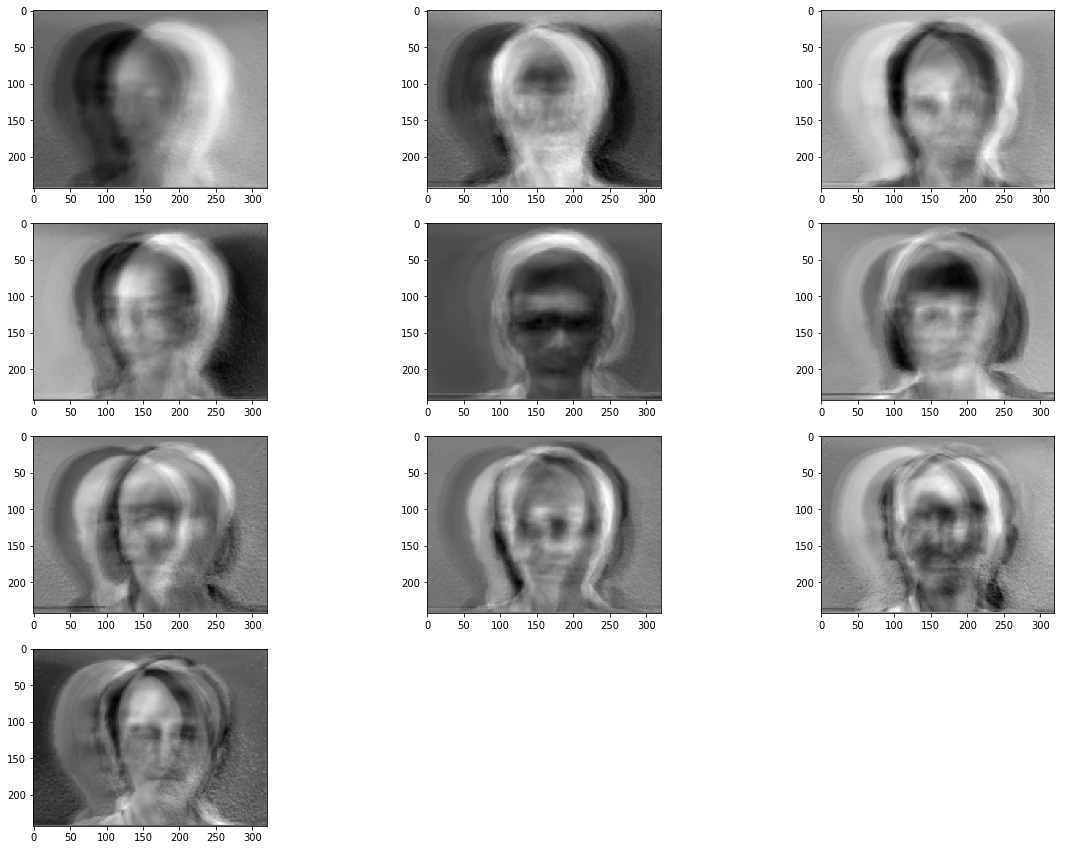

In [3]:
# top 10 eigenfaces
eigvecs = pca.components_
dim = data_tag.values()[0].shape

for i in range(10):
    eigvecs[i,:] -= np.min(eigvecs[i,:])
    eigvecs[i,:] *= 255.0/np.max(eigvecs[i,:])

val1 = [np.reshape(eigvecs[i, :], (dim[0], dim[1])) for i in range(10)]
val = [Image.fromarray(np.reshape(eigvecs[i, :], (dim[0], dim[1]))) for i in range(10)]

k = 1
plt.figure(figsize=[20,15])
for i in val:
    plt.subplot(4,3,k)
    plt.imshow(i)
    k += 1
plt.show()

77760
[-0.00036652 -0.00059332 -0.00069844 ...  0.          0.
  0.        ]


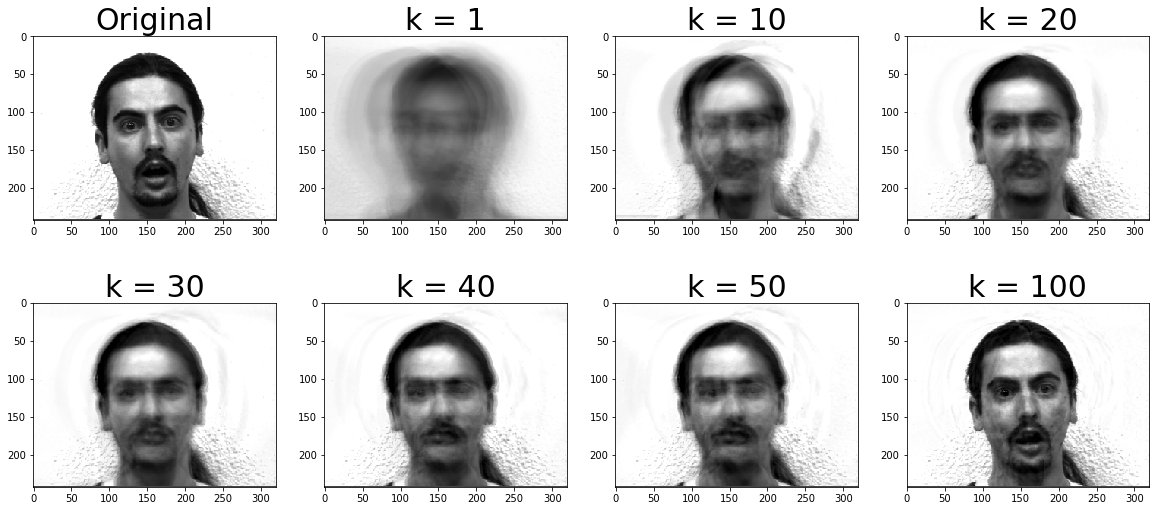

In [51]:
# reconstruct image using eigenvectors
# compute eigen analysis on the vectors
data = data_vec.values()
data = np.array(data)
n_feat = data.shape[1]
print n_feat
#print np.mean(data, axis=0).reshape(1, n_feat).shape
data_m = np.mean(data, axis=0)
data = data - np.mean(data, axis=0)

from sklearn.decomposition import PCA
pca = PCA(n_components=data.shape[0])
pca.fit(data)

eigvecs = normalize(pca.components_, norm='l2', axis=1)
print eigvecs[0,:]

def reconstruct(eigvecs, n_comp, m_data, X):
    temp = np.zeros((m_data.shape))
    for i in range(n_comp):
        temp += np.dot(eigvecs[i,:],X) * eigvecs[i,:]
    temp += m_data
    return temp

X = data_vec.values()[0] - data_m
Y = reconstruct(eigvecs, 1, data_m, X)

X = np.reshape(data_vec.values()[0], data_tag.values()[0].shape)
Y = np.reshape(Y, data_tag.values()[0].shape)

#print X
#print Y

X = Image.fromarray(X)
Y = Image.fromarray(Y)
#X.show()
#Y.show()
#plt.imshow(data_tag.values()[0], cmap='gray')
#plt.show()
#plt.imshow(Y)
#plt.show()

j = 1
plt.figure(figsize=[20,9])
for k in range(1,2,1):
    X = data_vec.values()[k] - data_m
    X_im = np.reshape(data_vec.values()[k], data_tag.values()[k].shape)
    plt.subplot(2,4,j)
    plt.imshow(X_im, cmap='gray')
    plt.title('Original', size=30)
    j += 1
    for i in range(1,8,1):
        if i > 1 and i != 7:
            i = i*10-10
        if i == 7:
            i = 100
        Y = reconstruct(eigvecs, i, data_m, X)
        Y_im = Image.fromarray(np.reshape(Y, data_tag.values()[k].shape))
        plt.subplot(2,4,j)
        plt.imshow(Y_im, cmap='gray')
        plt.title('k = ' + str(i), size=30)
        j += 1
plt.show()

In [116]:
# split data into train and test
from sklearn.model_selection import train_test_split
ids = []
labels = []
for k in data_tag.keys():
    ids.append(k)
    labels.append(k.split('.')[0])
ids = np.array(ids)
labels = np.array(labels)
train_ids, test_ids, train_labels, test_labels = train_test_split(ids, labels, test_size=0.2, stratify=labels)

X = np.array([data_vec[i] for i in list(train_ids)])
y = train_labels
pca = PCA(n_components=100)
X = pca.fit_transform(X)

In [118]:
# AdaBoostClassifier
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
acc = {}
for train_index, test_index in kf.split(X):
    for k in range(10, 100, 2):
        if k % 20 == 0:
            print k
        X = np.array([data_vec[i] for i in list(train_ids)])
        y = train_labels
        pca = PCA(n_components = k)
        X = pca.fit_transform(X)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5))
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)
        if acc.has_key(k):
            acc[k].append(accuracy_score(y_test, pred))
        else:
            acc[k] = [accuracy_score(y_test, pred)]
mean_acc = {}
for k,v in acc.items():
    mean_acc[k] = np.mean(np.array(v))
    
chosen_k = sorted((v,k) for k,v in mean_acc.items())[-1][1]
print mean_acc[chosen_k]

X = np.array([data_vec[i] for i in list(train_ids)])
y = train_labels
pca = PCA(n_components=chosen_k)
X = pca.fit_transform(X)
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5))
clf.fit(X, y)
test_data = np.array([data_vec[i] for i in list(test_ids)])
test_data = pca.transform(test_data)
pred = clf.predict(test_data)
print accuracy_score(test_labels, pred)
print chosen_k

20
40
60
80
20
40
60
80
20
40
60
80
20
40
60
80
20
40
60
80
0.7797720797720799
0.5294117647058824
24


In [124]:
# XGBoostClassifier
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import xgboost as xgb
acc = {}
for train_index, test_index in kf.split(X):
    for k in range(10,100,2):
        X = np.array([data_vec[i] for i in list(train_ids)])
        y = train_labels
        pca = PCA(n_components = k)
        X = pca.fit_transform(X)
        #print X.shape
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = xgb.XGBClassifier(max_depth=5)
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)
        if acc.has_key(k):
            acc[k].append(accuracy_score(y_test, pred))
        else:
            acc[k] = [accuracy_score(y_test, pred)]
mean_acc = {}
for k,v in acc.items():
    mean_acc[k] = np.mean(np.array(v))
    
chosen_k = sorted((v,k) for k,v in mean_acc.items())[-1][1]
print mean_acc[chosen_k]

X = np.array([data_vec[i] for i in list(train_ids)])
y = train_labels
pca = PCA(n_components=chosen_k)
X = pca.fit_transform(X)
clf = xgb.XGBClassifier(max_depth=5)
clf.fit(X, y)
test_data = np.array([data_vec[i] for i in list(test_ids)])
test_data = pca.transform(test_data)
pred = clf.predict(test_data)
print accuracy_score(test_labels, pred)
print chosen_k

/home/akhil/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/akhil/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/akhil/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/akhil/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/akhil/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/akhil/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/akhil/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/akhil/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/akhil/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/akhil/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/akhil/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/akhil/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/akhil/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/akhil/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/akhil/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/akhil/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/akhil/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/akhil/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/akhil/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/akhil/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/akhil/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/akhil/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/akhil/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/akhil/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/akhil/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/akhil/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/akhil/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/akhil/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/akhil/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/akhil/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/akhil/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/akhil/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

0.7655270655270655
0.7352941176470589
22


/home/akhil/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [121]:
# SVM - poly
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
acc = {}
for train_index, test_index in kf.split(X):
    for k in range(10, 100, 2):
        if k%50 == 0:
            print k
        X = np.array([data_vec[i] for i in list(train_ids)])
        y = train_labels
        pca = PCA(n_components = k)
        X = pca.fit_transform(X)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = SVC(kernel='poly')
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)
        if acc.has_key(k):
            acc[k].append(accuracy_score(y_test, pred))
        else:
            acc[k] = [accuracy_score(y_test, pred)]
mean_acc = {}
for k,v in acc.items():
    mean_acc[k] = np.mean(np.array(v))
    
chosen_k = sorted((v,k) for k,v in mean_acc.items())[-1][1]
print mean_acc[chosen_k]

X = np.array([data_vec[i] for i in list(train_ids)])
y = train_labels
pca = PCA(n_components=chosen_k)
X = pca.fit_transform(X)
clf = SVC(kernel='poly')
clf.fit(X, y)
test_data = np.array([data_vec[i] for i in list(test_ids)])
test_data = pca.transform(test_data)
pred = clf.predict(test_data)
print accuracy_score(test_labels, pred)
print chosen_k

50
50
50
50
50
0.7658119658119659
0.8235294117647058
50


In [122]:
# SVM - rbf
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
acc = {}
for train_index, test_index in kf.split(X):
    for k in range(10, 100, 2):
        if k%50 == 0:
            print k
        X = np.array([data_vec[i] for i in list(train_ids)])
        y = train_labels
        pca = PCA(n_components = k)
        X = pca.fit_transform(X)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = SVC(kernel='rbf')
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)
        if acc.has_key(k):
            acc[k].append(accuracy_score(y_test, pred))
        else:
            acc[k] = [accuracy_score(y_test, pred)]
mean_acc = {}
for k,v in acc.items():
    mean_acc[k] = np.mean(np.array(v))
    
chosen_k = sorted((v,k) for k,v in mean_acc.items())[-1][1]
print mean_acc[chosen_k]

X = np.array([data_vec[i] for i in list(train_ids)])
y = train_labels
pca = PCA(n_components=chosen_k)
X = pca.fit_transform(X)
clf = SVC(kernel='rbf')
clf.fit(X, y)
test_data = np.array([data_vec[i] for i in list(test_ids)])
test_data = pca.transform(test_data)
pred = clf.predict(test_data)
print accuracy_score(test_labels, pred)
print chosen_k

50
50
50
50
50
0.10655270655270654
0.17647058823529413
98


In [123]:
# SVM - linear
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
acc = {}
for train_index, test_index in kf.split(X):
    for k in range(10,100,2):
        if k%50 == 0:
            print k
        X = np.array([data_vec[i] for i in list(train_ids)])
        y = train_labels
        pca = PCA(n_components = k)
        X = pca.fit_transform(X)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = SVC(kernel='rbf')
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)
        if acc.has_key(k):
            acc[k].append(accuracy_score(y_test, pred))
        else:
            acc[k] = [accuracy_score(y_test, pred)]
mean_acc = {}
for k,v in acc.items():
    mean_acc[k] = np.mean(np.array(v))
    
chosen_k = sorted((v,k) for k,v in mean_acc.items())[-1][1]
print mean_acc[chosen_k]

X = np.array([data_vec[i] for i in list(train_ids)])
y = train_labels
pca = PCA(n_components=chosen_k)
X = pca.fit_transform(X)
clf = SVC(kernel='linear')
clf.fit(X, y)
test_data = np.array([data_vec[i] for i in list(test_ids)])
test_data = pca.transform(test_data)
pred = clf.predict(test_data)
print accuracy_score(test_labels, pred)
print chosen_k

50
50
50
50
50
0.10655270655270654
0.9117647058823529
98


In [71]:
mean_acc

{10: 0.05299145299145299,
 20: 0.05299145299145299,
 25: 0.05299145299145299,
 50: 0.05299145299145299,
 75: 0.05299145299145299,
 100: 0.05299145299145299,
 125: 0.05299145299145299}

In [135]:
# NN
import keras
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
enc = LabelBinarizer()

acc = {}
for train_index, test_index in kf.split(X):
    for k in range(10,100,10):
        if k%50 == 0:
            print k
        X = np.array([data_vec[i] for i in list(train_ids)])
        y = train_labels
        pca = PCA(n_components = k)
        X = pca.fit_transform(X)
        X_train, X_test = X[train_index], X[test_index]
        y_trainl, y_testl = y[train_index], y[test_index]
        y_train = enc.fit_transform(y_trainl)
        y_test = enc.transform(y_testl)
        model = Sequential()
        model.add(Dense(40, input_dim=X.shape[1]))
        model.add(Activation('relu'))
        model.add(Dense(15))
        model.add(Activation('softmax'))
        #model.summary()
        opt = keras.optimizers.rmsprop(lr=0.001)
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
        model.fit(X_train, y_train, batch_size=32, validation_split=0.2, shuffle=True)
        pred = model.predict_classes(X_test)
        te_y = np.dot(y_test, np.array([[1],[2],[3],[4],[5],[6],[7],[8],[9],[10],[11],[12],[13],[14],[15]])).transpose()[0]
        if acc.has_key(k):
            acc[k].append(accuracy_score(te_y, pred))
        else:
            acc[k] = [accuracy_score(te_y, pred)]
mean_acc = {}
for k,v in acc.items():
    mean_acc[k] = np.mean(np.array(v))
    
chosen_k = sorted((v,k) for k,v in mean_acc.items())[-1][1]
print mean_acc[chosen_k]

X = np.array([data_vec[i] for i in list(train_ids)])
y = train_labels
y = enc.fit_transform(y)
pca = PCA(n_components=chosen_k)
X = pca.fit_transform(X)
print X.shape
model = Sequential()
model.add(Dense(40, input_dim=X.shape[1]))
model.add(Activation('relu'))
model.add(Dense(15))
model.add(Activation('softmax'))
#model.summary()
opt = keras.optimizers.rmsprop(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.fit(X, y, batch_size=32, shuffle=True)
test_data = np.array([data_vec[i] for i in list(test_ids)])
test_data = pca.transform(test_data)
pred = model.predict_classes(test_data)
print pred
print test_labels
print accuracy_score(test_labels, pred)

Train on 84 samples, validate on 21 samples
Epoch 1/10
84/84 [==============================] - 0s - loss: 15.5424 - acc: 0.0357 - val_loss: 15.4677 - val_acc: 0.0000e+00
Epoch 2/10
84/84 [==============================] - 0s - loss: 15.5424 - acc: 0.0357 - val_loss: 15.4677 - val_acc: 0.0000e+00
Epoch 3/10
84/84 [==============================] - 0s - loss: 15.5424 - acc: 0.0357 - val_loss: 15.4677 - val_acc: 0.0000e+00
Epoch 4/10
84/84 [==============================] - 0s - loss: 15.5424 - acc: 0.0357 - val_loss: 15.4677 - val_acc: 0.0000e+00
Epoch 5/10
84/84 [==============================] - 0s - loss: 15.5424 - acc: 0.0357 - val_loss: 15.4677 - val_acc: 0.0000e+00
Epoch 6/10
84/84 [==============================] - 0s - loss: 15.5424 - acc: 0.0357 - val_loss: 15.4677 - val_acc: 0.0000e+00
Epoch 7/10
84/84 [==============================] - 0s - loss: 15.5424 - acc: 0.0357 - val_loss: 15.4677 - val_acc: 0.0000e+00
Epoch 8/10
84/84 [==============================] - 0s - loss: 15.5

84/84 [==============================] - 0s - loss: 14.7749 - acc: 0.0833 - val_loss: 15.3506 - val_acc: 0.0476
Epoch 2/10
84/84 [==============================] - 0s - loss: 14.7749 - acc: 0.0833 - val_loss: 15.3506 - val_acc: 0.0476
Epoch 3/10
84/84 [==============================] - 0s - loss: 14.7749 - acc: 0.0833 - val_loss: 15.3506 - val_acc: 0.0476
Epoch 4/10
84/84 [==============================] - 0s - loss: 14.7749 - acc: 0.0833 - val_loss: 15.3506 - val_acc: 0.0476
Epoch 5/10
84/84 [==============================] - 0s - loss: 14.7749 - acc: 0.0833 - val_loss: 15.3506 - val_acc: 0.0476
Epoch 6/10
84/84 [==============================] - 0s - loss: 14.7749 - acc: 0.0833 - val_loss: 15.3506 - val_acc: 0.0476
Epoch 7/10
84/84 [==============================] - 0s - loss: 14.7749 - acc: 0.0833 - val_loss: 15.3506 - val_acc: 0.0476
Epoch 8/10
84/84 [==============================] - 0s - loss: 14.7749 - acc: 0.0833 - val_loss: 15.3506 - val_acc: 0.0476
Epoch 9/10
84/84 [=========

84/84 [==============================] - 0s - loss: 14.3912 - acc: 0.1071 - val_loss: 11.5129 - val_acc: 0.2857
Epoch 3/10
84/84 [==============================] - 0s - loss: 14.3912 - acc: 0.1071 - val_loss: 11.5129 - val_acc: 0.2857
Epoch 4/10
84/84 [==============================] - 0s - loss: 14.3912 - acc: 0.1071 - val_loss: 11.5129 - val_acc: 0.2857
Epoch 5/10
84/84 [==============================] - 0s - loss: 14.3912 - acc: 0.1071 - val_loss: 11.5129 - val_acc: 0.2857
Epoch 6/10
84/84 [==============================] - 0s - loss: 14.3912 - acc: 0.1071 - val_loss: 11.5129 - val_acc: 0.2857
Epoch 7/10
84/84 [==============================] - 0s - loss: 14.3912 - acc: 0.1071 - val_loss: 11.5129 - val_acc: 0.2857
Epoch 8/10
84/84 [==============================] - 0s - loss: 14.3912 - acc: 0.1071 - val_loss: 11.5129 - val_acc: 0.2857
Epoch 9/10
84/84 [==============================] - 0s - loss: 14.3912 - acc: 0.1071 - val_loss: 11.5129 - val_acc: 0.2857
Epoch 10/10
27/27 [========

84/84 [==============================] - 0s - loss: 14.1993 - acc: 0.1190 - val_loss: 14.6528 - val_acc: 0.0909
Epoch 5/10
84/84 [==============================] - 0s - loss: 14.1993 - acc: 0.1190 - val_loss: 14.6528 - val_acc: 0.0909
Epoch 6/10
84/84 [==============================] - 0s - loss: 14.1993 - acc: 0.1190 - val_loss: 14.6528 - val_acc: 0.0909
Epoch 7/10
84/84 [==============================] - 0s - loss: 14.1993 - acc: 0.1190 - val_loss: 14.6528 - val_acc: 0.0909
Epoch 8/10
84/84 [==============================] - 0s - loss: 14.1993 - acc: 0.1190 - val_loss: 14.6528 - val_acc: 0.0909
Epoch 9/10
84/84 [==============================] - 0s - loss: 14.1993 - acc: 0.1190 - val_loss: 14.6528 - val_acc: 0.0909
Epoch 10/10
26/26 [==============================] - 0s
Train on 84 samples, validate on 22 samples
Epoch 1/10
84/84 [==============================] - 0s - loss: 16.1181 - acc: 0.0000e+00 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 2/10
84/84 [========================

84/84 [==============================] - 0s - loss: 14.3912 - acc: 0.1071 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 5/10
84/84 [==============================] - 0s - loss: 14.3912 - acc: 0.1071 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 6/10
84/84 [==============================] - 0s - loss: 14.3912 - acc: 0.1071 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 7/10
84/84 [==============================] - 0s - loss: 14.3912 - acc: 0.1071 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 8/10
84/84 [==============================] - 0s - loss: 14.3912 - acc: 0.1071 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 9/10
84/84 [==============================] - 0s - loss: 14.3912 - acc: 0.1071 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 10/10
26/26 [==============================] - 0s
Train on 84 samples, validate on 22 samples
Epoch 1/10
84/84 [==============================] - 0s - loss: 15.5424 - acc: 0.0357 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 2/10
84/84 [==============================] 

84/84 [==============================] - 0s - loss: 15.3506 - acc: 0.0476 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 7/10
84/84 [==============================] - 0s - loss: 15.3506 - acc: 0.0476 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 8/10
84/84 [==============================] - 0s - loss: 15.3506 - acc: 0.0476 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 9/10
84/84 [==============================] - 0s - loss: 15.3506 - acc: 0.0476 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 10/10
26/26 [==============================] - 0s
50
Train on 84 samples, validate on 22 samples
Epoch 1/10
84/84 [==============================] - 0s - loss: 14.6890 - acc: 0.0833 - val_loss: 14.6528 - val_acc: 0.0909
Epoch 2/10
84/84 [==============================] - 0s - loss: 14.5830 - acc: 0.0952 - val_loss: 14.6528 - val_acc: 0.0909
Epoch 3/10
84/84 [==============================] - 0s - loss: 14.5830 - acc: 0.0952 - val_loss: 14.6528 - val_acc: 0.0909
Epoch 4/10
84/84 [=============================

84/84 [==============================] - 0s - loss: 15.5424 - acc: 0.0357 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 8/10
84/84 [==============================] - 0s - loss: 15.5424 - acc: 0.0357 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 9/10
84/84 [==============================] - 0s - loss: 15.5424 - acc: 0.0357 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 10/10
26/26 [==============================] - 0s
Train on 84 samples, validate on 22 samples
Epoch 1/10
84/84 [==============================] - 0s - loss: 14.3912 - acc: 0.1071 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 2/10
84/84 [==============================] - 0s - loss: 14.3912 - acc: 0.1071 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 3/10
84/84 [==============================] - 0s - loss: 14.3912 - acc: 0.1071 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 4/10
84/84 [==============================] - 0s - loss: 14.3912 - acc: 0.1071 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 5/10
84/84 [==============================] 

84/84 [==============================] - 0s - loss: 15.5424 - acc: 0.0357 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 9/10
84/84 [==============================] - 0s - loss: 15.5424 - acc: 0.0357 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 10/10
26/26 [==============================] - 0s
Train on 84 samples, validate on 22 samples
Epoch 1/10
84/84 [==============================] - 1s - loss: 14.9668 - acc: 0.0714 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 2/10
84/84 [==============================] - 0s - loss: 14.9668 - acc: 0.0714 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 3/10
84/84 [==============================] - 0s - loss: 14.9668 - acc: 0.0714 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 4/10
84/84 [==============================] - 0s - loss: 14.9668 - acc: 0.0714 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 5/10
84/84 [==============================] - 0s - loss: 14.9668 - acc: 0.0714 - val_loss: 15.3855 - val_acc: 0.0455
Epoch 6/10
84/84 [========================

ValueError: Error when checking model input: expected dense_input_47 to have shape (None, 40) but got array with shape (106, 90)

In [141]:
X = np.array([data_vec[i] for i in list(train_ids)])
y = train_labels
y = enc.fit_transform(y)
pca = PCA(n_components=chosen_k)
X = pca.fit_transform(X)
print X.shape
model = Sequential()
model.add(Dense(40, input_dim=X.shape[1]))
model.add(Activation('relu'))
model.add(Dense(15))
model.add(Activation('softmax'))
#model.summary()
opt = keras.optimizers.rmsprop(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.fit(X, y, batch_size=32, shuffle=True)
test_data = np.array([data_vec[i] for i in list(test_ids)])
test_data = pca.transform(test_data)
pred = model.predict_classes(test_data)
print pred
print test_labels
print accuracy_score(test_labels, pred)

(132, 40)
Epoch 1/10
132/132 [==============================] - 1s - loss: 14.8970 - acc: 0.0758     
Epoch 2/10
132/132 [==============================] - 0s - loss: 14.8970 - acc: 0.0758     
Epoch 3/10
132/132 [==============================] - 0s - loss: 14.8970 - acc: 0.0758     
Epoch 4/10
132/132 [==============================] - 0s - loss: 14.8970 - acc: 0.0758     
Epoch 5/10
132/132 [==============================] - 0s - loss: 14.8970 - acc: 0.0758     
Epoch 6/10
132/132 [==============================] - 0s - loss: 14.8970 - acc: 0.0758     
Epoch 7/10
132/132 [==============================] - 0s - loss: 14.8970 - acc: 0.0758     
Epoch 8/10
132/132 [==============================] - 0s - loss: 14.8970 - acc: 0.0758     
Epoch 9/10
132/132 [==============================] - 0s - loss: 14.8970 - acc: 0.0758     
Epoch 10/10
32/34 [===========================>..] - ETA: 0s[ 4 11  0  5  0  0 11  5 11 11 11 10  0 11  5  0 11  1 10 11 11  0  0 11
  0  7  5  5  0 11 11 11 11 1

In [104]:
len(set(types))

12

In [110]:
# Type recognition
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()

ids = []
types = []
for k in data_tag.keys():
    ids.append(k)
    types.append(k.split('.')[1])
ids = np.array(ids)
types = np.array(types)
#types = enc.fit_transform(np.array(types))

# clustering in n dimensions
acc = {}
gmms = {}
for n in range(10, 120, 10):
    X = np.array([data_vec[i] for i in list(ids)])
    y = types
    pca = PCA(n_components=n)
    X = pca.fit_transform(X)
    gmm = GaussianMixture(n_components=len(set(types)), covariance_type='diag')
    labels = gmm.fit(X).predict(X)
    from scipy import stats
    tot = 0
    mixtures = []
    for i in range(12):
        mix = types[labels==i]
        tot += np.sum(mix == stats.mode(mix, axis=None))
        mixtures.append(list(mix))
    acc[n] = tot/float(167)
    gmms[n] = mixtures
    
chosen_k = sorted((v,k) for k,v in acc.items())[-1][1]
for i in gmms[chosen_k]:
    print i
    print ''
print chosen_k
print acc[chosen_k]
print sorted((v,k) for k,v in acc.items())

['happy', 'rightlight', 'surprised', 'sleepy', 'sad', 'centerlight', 'wink', 'centerlight', 'noglasses', 'glasses', 'normal']

['surprised', 'sleepy', 'happy', 'glasses', 'normal', 'sad', 'sad', 'sleepy', 'noglasses', 'happy', 'wink', 'normal', 'happy', 'surprised', 'centerlight', 'sleepy', 'wink', 'normal', 'normal', 'glasses', 'normal', 'centerlight', 'happy', 'sleepy', 'wink', 'noglasses', 'noglasses', 'sad', 'surprised', 'centerlight']

['centerlight', 'noglasses', 'glasses', 'surprised', 'sad', 'happy', 'wink', 'rightlight', 'rightlight', 'sleepy', 'normal']

['leftlight', 'leftlight', 'leftlight', 'leftlight', 'leftlight', 'leftlight', 'leftlight', 'leftlight', 'leftlight', 'leftlight', 'leftlight', 'leftlight', 'leftlight', 'leftlight', 'leftlight']

['centerlight', 'noglasses', 'happy', 'noglasses', 'glasses', 'centerlight', 'normal', 'glasses', 'surprised', 'rightlight', 'sad', 'wink', 'sleepy', 'noglasses', 'normal']

['happy', 'rightlight', 'normal', 'sleepy', 'noglasses', '

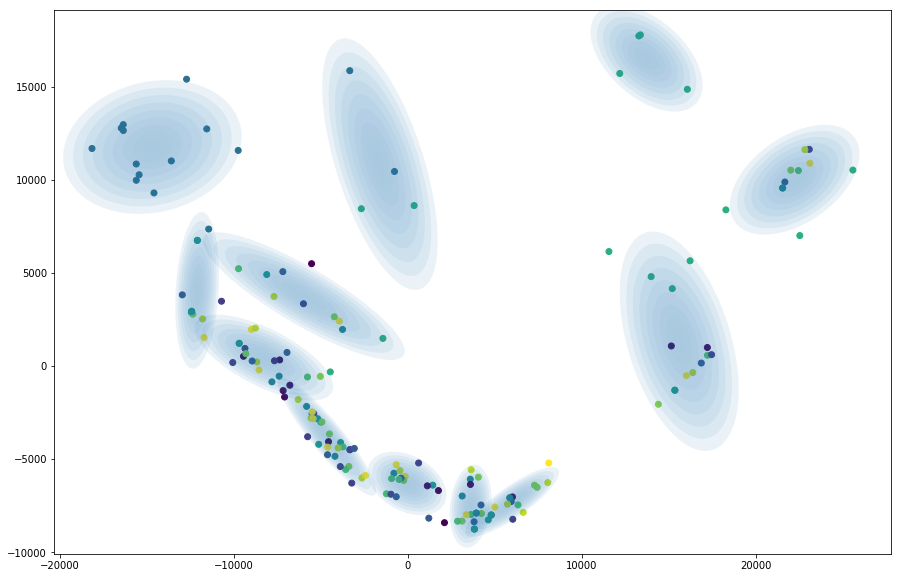

In [109]:
# plotting with clustering in 2 dimensions
X = np.array([data_vec[i] for i in list(ids)])
y = types
pca = PCA(n_components=2)
X = pca.fit_transform(X)
types = enc.fit_transform(np.array(types))

from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
gmm = GaussianMixture(n_components=len(set(types)), covariance_type='full')
labels = gmm.fit(X).predict(X)
plt.figure(figsize=[15,10])
ax = plt.gca()
ax.scatter(X[:, 0], X[:, 1], c=types, cmap='viridis')
ax.legend()
for p,c in zip(gmm.means_, gmm.covariances_):
    U, s, Ut = np.linalg.svd(c)
    angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
    c = np.sqrt(s)
    for i in range(1,10,1):
        ax.add_patch(Ellipse(p, i*c[0]/2.0, i*c[1]/2.0, angle, alpha=i*0.01))
plt.show()